In [1]:
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
import scipy.stats as stats

In [2]:
# Open JSON files with article information (the data was collected on two occations)
with open("../articles.json") as file:
    a = file.readlines()
with open("../articles2.json") as file:
    a2 = file.readlines()

# Concatenate the two files into one list
a_con = a+a2    

In [3]:
# Convert the "string JSON" to dictionaries
a_list = []
for item in a_con:
    a_list.append(ast.literal_eval(item))

In [4]:
title_df = pd.DataFrame()
comment_df = pd.DataFrame()
for article in a_list:
    # Extract relevant information from article itself
    title = article["article"]["title"] # title
    id = article["article"]["id"] # article id
    tag = article["article"]["nodeRef"]["title"] # tags (politics, economy, culture...)
    total_comments = article["totalComments"] # number of comments
    # Append to the article DataFrame
    title_df = pd.concat([title_df,pd.DataFrame([{"id":id,"title":title,"tag":tag,"total_comments":total_comments}])],ignore_index=True)

    # Make sure that the article contains comments
    if title_df["total_comments"].iloc[-1]!=0:
        # Get comments
        name = article["article"]["title"]
        df = pd.DataFrame(article["comments"])
        # Drop last name (assume that the name is in format First (Second) Last) -> some names will be wrong
        # All names are also made into lower case for easier comparison
        df["name"] = df["userIdentity"].apply(lambda x: x["displayName"].split(" ")[0].lower())
        # Extract just votes (gets rid of unnecessary metadata)
        df["votes"] = df["votes"].apply(lambda x: x["totalPositiveVotes"])
        df = df.drop(["id","userIdentity","product"],axis=1)
        # Append to comment DataFrame
        comment_df = pd.concat([comment_df,df],ignore_index=True)
# Drop parent information (parent = original comment that is being referenced by child comment)
comment_df = comment_df.drop(["parent","parentId"],axis=1)
# Include comment length as a column
comment_df["len_of_comment"] = comment_df["comment"].apply(lambda x: len(x))

In [5]:
# Example of title_df:
title_df.head()

,id,title,tag,total_comments
0,2000010699910,Puolustus­ministerit: Ruotsille kaavaillaan jo...,Politiikka,5
1,2000010699952,Sisämarkkinakomissaari Breton eroaa – syyttää ...,Politiikka,5
2,2000010699254,EU:n hinta jokaista suomalaista kohden nousi v...,Politiikka,6
3,2000010699623,SvD: Ruotsille pää­vastuu Suomeen tulevista Na...,Politiikka,8
4,2000010699070,Suomen ja Ruotsin hallitukset tapaavat Tukholm...,Politiikka,4


In [6]:
# Ecample of comment_df:
comment_df.head()

,articleId,comment,votes,createdAt,name,len_of_comment
0,2000010699910,Tulee mieliin lapsuudesta vitivalkoisiin turkk...,0,1726482942215,tapani,228
1,2000010699910,"Ruotsalaiset johtoon, onkohan se nyt hyvä idea...",1,1726482513272,vesa,141
2,2000010699910,Suomi olisi uskottavampi maa johtamaan joukkoj...,1,1726482384787,henna,132
3,2000010699910,"Jaaha, nyt antaudutaan Venäjälle.",1,1726482384463,mikael,33
4,2000010699910,Ruotsi johtamassa Suomen puolustusta?<br>Vuott...,1,1726482301061,jari,206


count    219.000000
mean      36.406393
std       30.723451
min        0.000000
25%       14.000000
50%       28.000000
75%       52.500000
max      137.000000
Name: total_comments, dtype: float64


Text(0.5, 1.0, 'Distribution of comments per article')

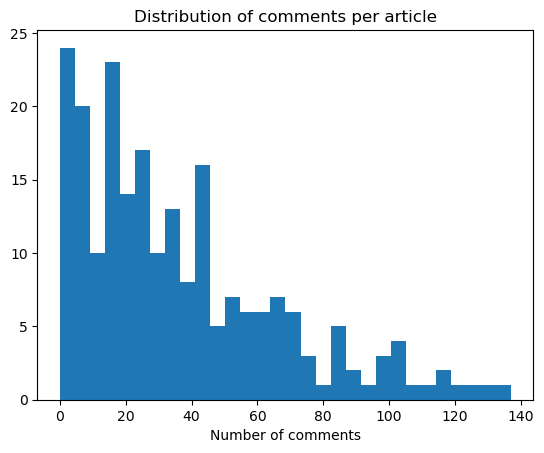

In [8]:
print(title_df["total_comments"].describe())
plt.hist(title_df["total_comments"],bins=30)
plt.xlabel("Number of comments")
plt.title("Distribution of comments per article")

count    7973.000000
mean       93.744011
std       189.904701
min         0.000000
25%         9.000000
50%        28.000000
75%        89.000000
max      2447.000000
Name: votes, dtype: float64


Text(0.5, 1.0, 'Distribution of votes on comments')

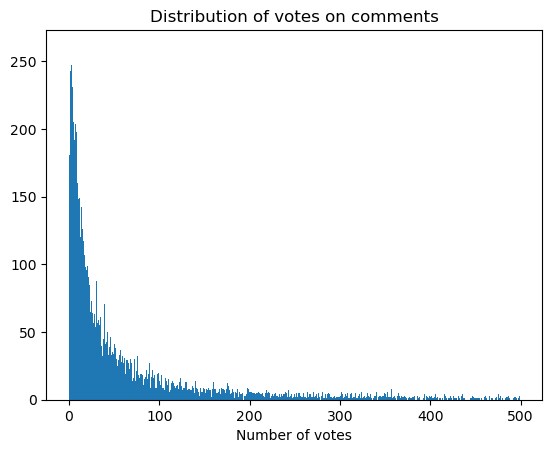

In [9]:
print(comment_df["votes"].describe())
plt.hist(comment_df["votes"],bins=range(0,500))
plt.xlabel("Number of votes")
plt.title("Distribution of votes on comments")

In [10]:
#comment_df["len_of_comment"] = comment_df["comment"].apply(lambda x: len(x))

count    7973.000000
mean      460.618713
std       374.907787
min        11.000000
25%       211.000000
50%       351.000000
75%       577.000000
max      2260.000000
Name: len_of_comment, dtype: float64


Text(0.5, 0, 'Length of comment')

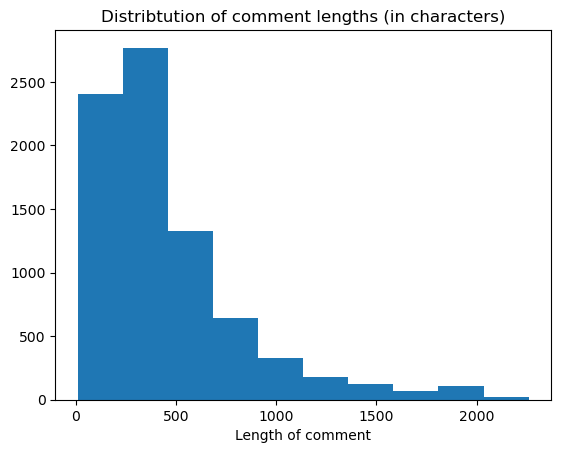

In [11]:
print(comment_df["len_of_comment"].describe())
plt.hist(comment_df["len_of_comment"]);
plt.title("Distribtution of comment lengths (in characters)")
plt.xlabel("Length of comment")

In [12]:
# Create a name list
men = pd.read_excel("etunimet.xlsx", sheet_name=0)
men["Etunimi"] = men["Etunimi"].str.lower()
women = pd.read_excel("etunimet.xlsx", sheet_name=3)
women["Etunimi"] = women["Etunimi"].str.lower()
names = pd.merge(women, men, how="outer", on='Etunimi') 

In [13]:
def assign_gender(x):
    # Man = 1, Woman = 0, not known = NaN
    if x["Lukumäärä_x"]>x["Lukumäärä_y"] or np.isnan(x["Lukumäärä_y"]):
        return 0
    elif x["Lukumäärä_x"]<x["Lukumäärä_y"] or np.isnan(x["Lukumäärä_x"]):
        return 1
    return np.nan

# Creating gender column
names["Gender"] = names.apply(assign_gender,axis=1)

In [15]:
# Adding gender column
comment_df = pd.merge(comment_df,names[["Etunimi","Gender"]],left_on="name",right_on="Etunimi",how="left").drop(["Etunimi","name"],axis=1)

In [16]:
print("Number of comments with missing gender information:", len(comment_df[comment_df["Gender"].isna()]))

Number of comments with missing gender information: 299


In [17]:
# # Lowercasing words
# comment_df["comment"] = comment_df["comment"].str.lower()
# Removing br-tags
comment_df['comment'] = comment_df['comment'].str.replace(r'<br>|</br>', ' ', regex=True)
# # Removing punctuation
# comment_df['comment'] = comment_df['comment'].str.replace(r'[^\w\s]+', '', regex=True)

In [36]:
# # Load stopwords
# with open("stopwords-fi.txt") as f:
#     stopwords = set(f.read().split("\n"))

# # Removing stopwords
# comment_df['comment'] = comment_df['comment'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stopwords)]))

In [37]:
# from nltk.stem.snowball import SnowballStemmer
# # Create a stemmer (snowball was chosen for Finnish language support)
# stemmer = SnowballStemmer("finnish")
# comment_df["comment"] = comment_df["comment"].apply(lambda x: " ".join(stemmer.stem(w) for w in x.split()))

In [56]:
# Create a text classification pipeline with FINBERT
pipe = pipeline("text-classification", model="fergusq/finbert-finnsentiment")

c:\Users\joona\anaconda3\envs\project_data\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
print("En voi ymmärtää...",pipe("En voi ymmärtää...")[0])
print("En voi ymmärtää",pipe("En voi ymmärtää")[0])
print("En voi ymmärtää!",pipe("En voi ymmärtää!")[0])
print("En voi ymmärtää!!!",pipe("En voi ymmärtää!!!")[0])
print("EN VOI YMMÄRTÄÄ!!!",pipe("EN VOI YMMÄRTÄÄ!!!")[0])

# As we can see, format matter. This is why we decided agaist processing of the comments

En voi ymmärtää... {'label': 'NEGATIVE', 'score': 0.8703657984733582}
En voi ymmärtää {'label': 'NEGATIVE', 'score': 0.9024980068206787}
En voi ymmärtää! {'label': 'NEGATIVE', 'score': 0.9813575744628906}
En voi ymmärtää!!! {'label': 'NEGATIVE', 'score': 0.9901602864265442}
EN VOI YMMÄRTÄÄ!!! {'label': 'NEGATIVE', 'score': 0.9920434355735779}


In [20]:
# The number of tokens was too high for a certain comment
# Here we find the longest comment (number of words)
max_len = comment_df["comment"].str.split().apply(lambda x: len(x)).max()
# Find index corresponding to this longest comment
idx = comment_df["comment"][comment_df["comment"].str.split().apply(lambda x: len(x))==max_len]
# Drop the troublesome comment
comment_df = comment_df.drop(index=idx.index)

In [66]:
%%time
# Find sentiments for comments (this takes a long time!)
comment_df["sentiment"] = comment_df["comment"].apply(lambda x: pipe(inputs=x)[0]["label"])

CPU times: total: 1h 16min 27s
Wall time: 19min 22s


In [67]:
# Save the results to CSV (in case something goes wrong since we don't want to waste an hour in recomputation)
comment_df.to_csv("comment.csv",index=False)

In [166]:
# # In case the DataFrame needs to be read again
# comment_df = pd.read_csv("comment.csv")

In [69]:
num_men = len(comment_df[comment_df["Gender"]==1])
num_women = len(comment_df[comment_df["Gender"]==0])
p_men = len(comment_df[(comment_df["Gender"]==1) & (comment_df["sentiment"]=="POSITIVE")])
p_women = len(comment_df[(comment_df["Gender"]==0) & (comment_df["sentiment"]=="POSITIVE")])
n_men = len(comment_df[(comment_df["Gender"]==1) & (comment_df["sentiment"]=="NEUTRAL")])
n_women = len(comment_df[(comment_df["Gender"]==0) & (comment_df["sentiment"]=="NEUTRAL")])
neg_men = len(comment_df[(comment_df["Gender"]==1) & (comment_df["sentiment"]=="NEGATIVE")])
neg_women = len(comment_df[(comment_df["Gender"]==0) & (comment_df["sentiment"]=="NEGATIVE")])
print("Positive (men-women)")
print(p_men/num_men*100)
print(p_women/num_women*100)
print("Neutral (men-women)")
print(n_men/num_men*100)
print(n_women/num_women*100)
print("Negative (men-women)")
print(neg_men/num_men*100)
print(neg_women/num_women*100)
print(p_men+n_men+neg_men,num_men)
print(p_women+n_women+neg_women,num_women)

Positive (men-women)
1.6164337430543863
2.364475201845444
Neutral (men-women)
74.18757366560027
71.79930795847751
Negative (men-women)
24.195992591345345
25.836216839677046
5939 5939
1734 1734


In [70]:
# Expected frequencies if gender doesn't matter
f_exp = len(comment_df[comment_df["sentiment"]=="POSITIVE"])/len(comment_df),len(comment_df[comment_df["sentiment"]=="NEUTRAL"])/len(comment_df),len(comment_df[comment_df["sentiment"]=="NEGATIVE"])/len(comment_df)
# Null hypothesis: gender doesn't affect sentiment
print(stats.chisquare(f_obs=[p_men/num_men,n_men/num_men,neg_men/num_men],f_exp=f_exp))
# High p-value indicates that probability of seeing the observed frequecies when the null hypothesis is true is high
# In this case we cannot argue that the null hypothesis is false

Power_divergenceResult(statistic=0.00026209843026484946, pvalue=0.9998689593714408)


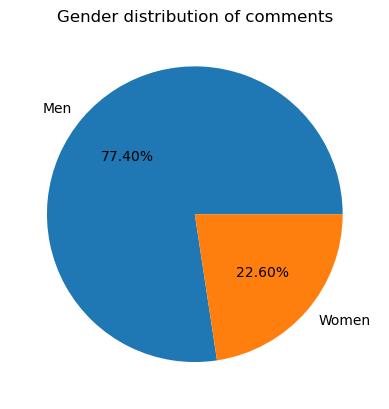

In [71]:
plt.pie([num_men,num_women],labels=["Men","Women"],autopct=lambda x: f"{x:.2f}%")
plt.title("Gender distribution of comments")
plt.savefig("piechart.png")

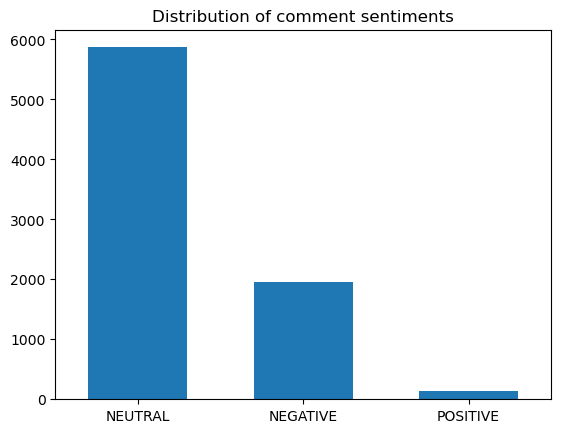

In [72]:
bins = np.arange(4) - 0.3
plt.hist(comment_df["sentiment"],bins=bins,width=0.6)
plt.xlim(-0.5,2.5)
plt.title("Distribution of comment sentiments")
plt.savefig("images/sentiment_distribution.png")

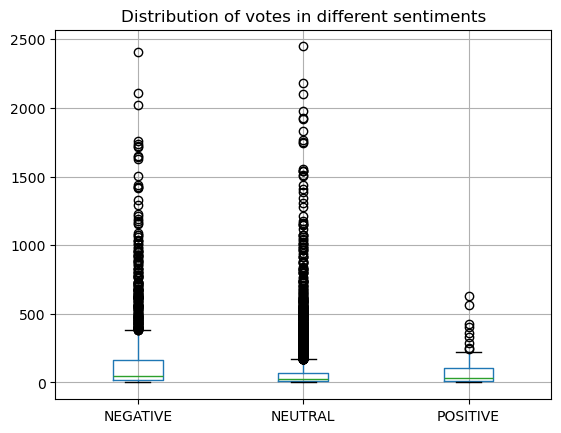

In [73]:
# Default boxplot
test = comment_df[["votes","sentiment"]].pivot(values=["votes"],columns=["sentiment"])
test.columns = test.columns.droplevel(0)
test.boxplot()
plt.title("Distribution of votes in different sentiments")
plt.savefig("images/boxplot.png")

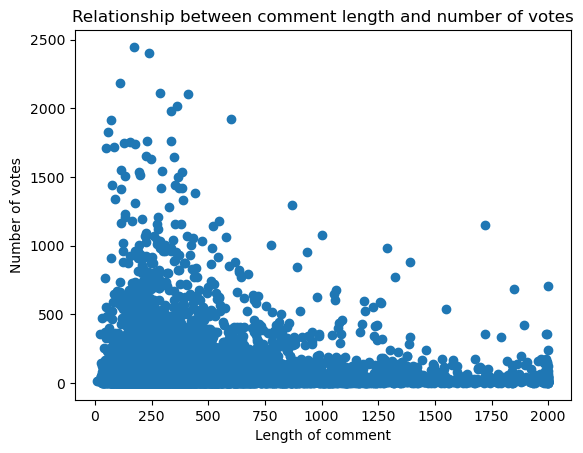

In [74]:
plt.scatter(comment_df["comment"].str.len(),comment_df["votes"])
plt.xlabel("Length of comment")
plt.ylabel("Number of votes")
plt.title("Relationship between comment length and number of votes")
plt.savefig("images/votesLength.png")